Josh and I have talked about using Stable Diffusion to generate a new version of the logo on our
landing page every day. Stable diffusion alone hasn't been able to generate anything meaningful, but
let's try creating seed images with DalleMini and then use Stable Diffusion img2img to refine them.

_Based on: https://github.com/huggingface/diffusers/blob/main/README.md#image-to-image-text-guided-generation-with-stable-diffusion_

In [ ]:
!pip install --index-url https://api.run.house/pypi runhouse-nightly==0.0.1.dev20221203

In [ ]:
import runhouse as rh
import torch
from PIL import Image
import random

rh_prompt = 'A digital illustration of a woman running on the roof of a house.'

First try just DalleMini. It runs best on an A100, but AWS doesn't offer single A100s (only clusters of 8),
so let's run it on gcp.
gcp_gpu = rh.cluster(name='a100', instance_type='A100:1', provider='gcp', use_spot=True, autostop_mins=60)

In [ ]:
def dm_generate(prompt, num_images_sqrt=1, supercondition_factor=32, is_mega=True, seed=50, top_k=64):
    from min_dalle import MinDalle
    import torch
    from PIL import Image
    torch.cuda.empty_cache()
    torch.no_grad()
    dalle = MinDalle(device='cuda', is_mega=is_mega, is_reusable=False, dtype=torch.float16)
    images = dalle.generate_images(prompt, seed=seed, grid_size=num_images_sqrt,
                                   temperature=1, top_k=top_k, supercondition_factor=supercondition_factor)
    images = images.to(torch.uint8).to('cpu').numpy()
    return [Image.fromarray(images[i]) for i in range(num_images_sqrt**2)]

gcp_gpu = rh.cluster(name='a100', instance_type='A100:1', provider='gcp', use_spot=True, autostop_mins=60)
dm_generate_gpu = rh.send(fn=dm_generate, hardware=gcp_gpu,
                          reqs=['reqs:default', 'min-dalle'], create=True, serialize_notebook_fn=False)

In [ ]:
rh_logo_dm_images = dm_generate_gpu(rh_prompt, seed=random.randint(0, 1000),
                                    num_images_sqrt=2, supercondition_factor=256)
[image.show() for image in rh_logo_dm_images]

Now let's try feeding it into StableDiffusionImg2Img. We could put this on a the A100, but it might OOM,
so let's put it on a V100 on AWS.

In [ ]:
def sd_img2img_generate(prompt, base_images, num_images=1,
                        steps=100, strength=0.75, guidance_scale=7.5, model_id="runwayml/stable-diffusion-v1-5"):
    from diffusers import StableDiffusionImg2ImgPipeline
    import torch
    torch.cuda.empty_cache()
    torch.no_grad()
    sd_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id)
    sd_pipe = sd_pipe.to('cuda')
    ret = []
    for image in base_images:
        ret = ret + sd_pipe([prompt] * num_images, init_image=image.resize((512, 512)),
                            num_inference_steps=steps, strength=strength,
                            guidance_scale=guidance_scale).images
    return ret

# aws_gpu = rh.cluster(name='v100', instance_type='V100:1', provider='aws', use_spot=True, autostop_mins=60)
sd_img2img_generate_gpu = rh.send(fn=sd_img2img_generate, hardware='^rh-v100',
                                  reqs=['reqs:default', 'diffusers'],
                                  create=True, serialize_notebook_fn=False).send_secrets()

In [ ]:
rh_logo_dm2sd_images = sd_img2img_generate_gpu(rh_prompt, rh_logo_dm_images, strength=.75,
                                               guidance_scale=7.5, steps=25)
[image.show() for image in rh_logo_dm2sd_images]

Now let's do a tester passing an existing runhouse logo image to SDImg2Img.

INFO | 2022-11-23 05:11:08,453 | Running anonymous send via SSH
INFO | 2022-11-23 05:11:31,208 | Time to send message: 22.74 seconds


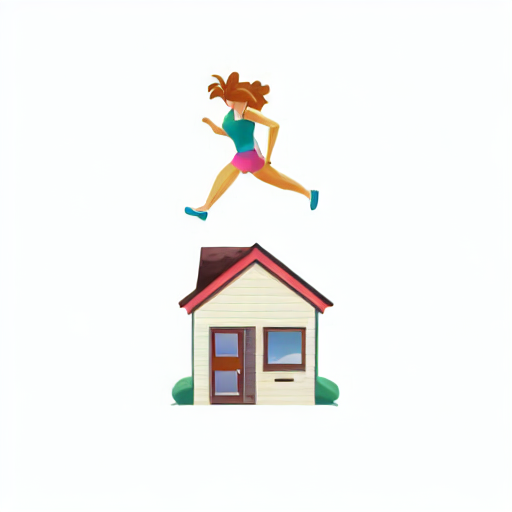

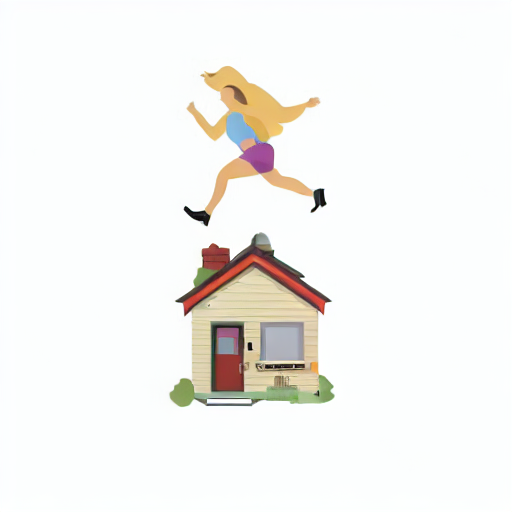

[None, None]

In [38]:
rh_base_image = Image.open('rh_logo.png').convert("RGB").resize((512, 512))
rh_logo_sd_images = sd_img2img_generate_gpu(rh_prompt, [rh_base_image],
                                            strength=.5, guidance_scale=5,
                                            num_images=2, steps=100)
[display(image) for image in rh_logo_sd_images]